## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
import numpy as np

a = np.arange(50000)
np.random.shuffle(a)
indexs = a[:5000]

x_train = x_train[indexs]
y_train = y_train[indexs]

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [12]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25, 0.5]
redice_lr_patient = [5, 10]

In [15]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-{}-{}-{}".format(optim,reduce_factor,reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_58 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_59 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________


5000/5000 [==============================] - 2s 377us/step - loss: 1.3928 - accuracy: 0.5260 - val_loss: 2.1396 - val_accuracy: 0.2369
Epoch 12/25
5000/5000 [==============================] - 2s 391us/step - loss: 1.3387 - accuracy: 0.5446 - val_loss: 2.1272 - val_accuracy: 0.2461
Epoch 13/25
5000/5000 [==============================] - 2s 349us/step - loss: 1.2864 - accuracy: 0.5692 - val_loss: 2.1132 - val_accuracy: 0.2542
Epoch 14/25
5000/5000 [==============================] - 2s 328us/step - loss: 1.2397 - accuracy: 0.5944 - val_loss: 2.1005 - val_accuracy: 0.2619
Epoch 15/25
5000/5000 [==============================] - 2s 348us/step - loss: 1.1972 - accuracy: 0.6116 - val_loss: 2.0878 - val_accuracy: 0.2637
Epoch 16/25
5000/5000 [==============================] - 1s 268us/step - loss: 1.1588 - accuracy: 0.6306 - val_loss: 2.0745 - val_accuracy: 0.2687
Epoch 17/25
5000/5000 [==============================] - 1s 237us/step - loss: 1.1197 - accuracy: 0.6472 - val_loss: 2.0639 - val_

Train on 5000 samples, validate on 10000 samples
Epoch 1/25
5000/5000 [==============================] - 2s 348us/step - loss: 3.0050 - accuracy: 0.1030 - val_loss: 2.3409 - val_accuracy: 0.1158
Epoch 2/25
5000/5000 [==============================] - 1s 219us/step - loss: 2.5507 - accuracy: 0.1870 - val_loss: 2.3038 - val_accuracy: 0.1402
Epoch 3/25
5000/5000 [==============================] - 1s 194us/step - loss: 2.2351 - accuracy: 0.2584 - val_loss: 2.2811 - val_accuracy: 0.1283
Epoch 4/25
5000/5000 [==============================] - 1s 195us/step - loss: 2.0444 - accuracy: 0.3118 - val_loss: 2.2676 - val_accuracy: 0.1313
Epoch 5/25
5000/5000 [==============================] - 1s 232us/step - loss: 1.8982 - accuracy: 0.3446 - val_loss: 2.2470 - val_accuracy: 0.1442
Epoch 6/25
5000/5000 [==============================] - 1s 197us/step - loss: 1.7803 - accuracy: 0.3850 - val_loss: 2.2243 - val_accuracy: 0.1607
Epoch 7/25
5000/5000 [==============================] - 1s 193us/step - los

5000/5000 [==============================] - 1s 195us/step - loss: 0.6859 - accuracy: 0.8322 - val_loss: 1.9050 - val_accuracy: 0.3340
Epoch 21/25
5000/5000 [==============================] - 1s 195us/step - loss: 0.6626 - accuracy: 0.8430 - val_loss: 1.8879 - val_accuracy: 0.3456
Epoch 22/25
5000/5000 [==============================] - 1s 196us/step - loss: 0.6400 - accuracy: 0.8492 - val_loss: 1.8816 - val_accuracy: 0.3433
Epoch 23/25
5000/5000 [==============================] - 1s 196us/step - loss: 0.6178 - accuracy: 0.8586 - val_loss: 1.8680 - val_accuracy: 0.3497
Epoch 24/25
5000/5000 [==============================] - 1s 194us/step - loss: 0.5986 - accuracy: 0.8664 - val_loss: 1.8435 - val_accuracy: 0.3662
Epoch 25/25
5000/5000 [==============================] - 1s 194us/step - loss: 0.5756 - accuracy: 0.8762 - val_loss: 1.8406 - val_accuracy: 0.3601
Numbers of exp: 5, reduce_factor: 0.25, reduce_patient: 10
Model: "model_25"
_____________________________________________________

5000/5000 [==============================] - 1s 201us/step - loss: 1.3871 - accuracy: 0.5294 - val_loss: 2.1321 - val_accuracy: 0.2318
Epoch 6/25
5000/5000 [==============================] - 1s 199us/step - loss: 1.2727 - accuracy: 0.5734 - val_loss: 2.1059 - val_accuracy: 0.2293
Epoch 7/25
5000/5000 [==============================] - 1s 206us/step - loss: 1.1826 - accuracy: 0.6124 - val_loss: 2.0950 - val_accuracy: 0.2503
Epoch 8/25
5000/5000 [==============================] - 1s 233us/step - loss: 1.0910 - accuracy: 0.6564 - val_loss: 2.0828 - val_accuracy: 0.2588
Epoch 9/25
5000/5000 [==============================] - 1s 204us/step - loss: 1.0128 - accuracy: 0.6860 - val_loss: 2.0806 - val_accuracy: 0.2481
Epoch 10/25
5000/5000 [==============================] - 1s 198us/step - loss: 0.9421 - accuracy: 0.7250 - val_loss: 2.0619 - val_accuracy: 0.2646
Epoch 11/25
5000/5000 [==============================] - 1s 198us/step - loss: 0.8751 - accuracy: 0.7548 - val_loss: 2.0516 - val_accu

5000/5000 [==============================] - 1s 208us/step - loss: 0.3187 - accuracy: 0.9712 - val_loss: 1.9039 - val_accuracy: 0.3404
Numbers of exp: 8, reduce_factor: 0.25, reduce_patient: 5
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_82 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)               1024      
_______________________________________________________________

5000/5000 [==============================] - 1s 191us/step - loss: 1.2733 - accuracy: 0.5854 - val_loss: 2.1787 - val_accuracy: 0.1713
Epoch 11/25
5000/5000 [==============================] - 1s 184us/step - loss: 1.2221 - accuracy: 0.6092 - val_loss: 2.1852 - val_accuracy: 0.1766
Epoch 12/25
5000/5000 [==============================] - 1s 186us/step - loss: 1.1683 - accuracy: 0.6266 - val_loss: 2.1647 - val_accuracy: 0.1961
Epoch 13/25
5000/5000 [==============================] - 1s 184us/step - loss: 1.1250 - accuracy: 0.6532 - val_loss: 2.1758 - val_accuracy: 0.1816
Epoch 14/25
5000/5000 [==============================] - 1s 185us/step - loss: 1.0793 - accuracy: 0.6706 - val_loss: 2.1488 - val_accuracy: 0.1994
Epoch 15/25
5000/5000 [==============================] - 1s 187us/step - loss: 1.0379 - accuracy: 0.6854 - val_loss: 2.1392 - val_accuracy: 0.1931
Epoch 16/25
5000/5000 [==============================] - 1s 186us/step - loss: 1.0008 - accuracy: 0.7092 - val_loss: 2.1460 - val_

Train on 5000 samples, validate on 10000 samples
Epoch 1/25
5000/5000 [==============================] - 2s 314us/step - loss: 2.6010 - accuracy: 0.1808 - val_loss: 2.3294 - val_accuracy: 0.1157
Epoch 2/25
5000/5000 [==============================] - 1s 188us/step - loss: 2.0690 - accuracy: 0.2996 - val_loss: 2.2963 - val_accuracy: 0.1267
Epoch 3/25
5000/5000 [==============================] - 1s 191us/step - loss: 1.8687 - accuracy: 0.3582 - val_loss: 2.2675 - val_accuracy: 0.1282
Epoch 4/25
5000/5000 [==============================] - 1s 190us/step - loss: 1.7406 - accuracy: 0.4028 - val_loss: 2.2410 - val_accuracy: 0.1532
Epoch 5/25
5000/5000 [==============================] - 1s 191us/step - loss: 1.6328 - accuracy: 0.4386 - val_loss: 2.2235 - val_accuracy: 0.1668
Epoch 6/25
5000/5000 [==============================] - 1s 192us/step - loss: 1.5480 - accuracy: 0.4664 - val_loss: 2.2081 - val_accuracy: 0.1788
Epoch 7/25
5000/5000 [==============================] - 1s 190us/step - los

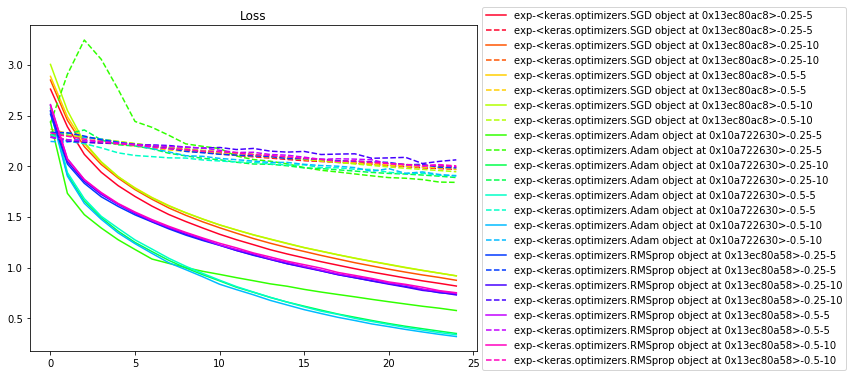

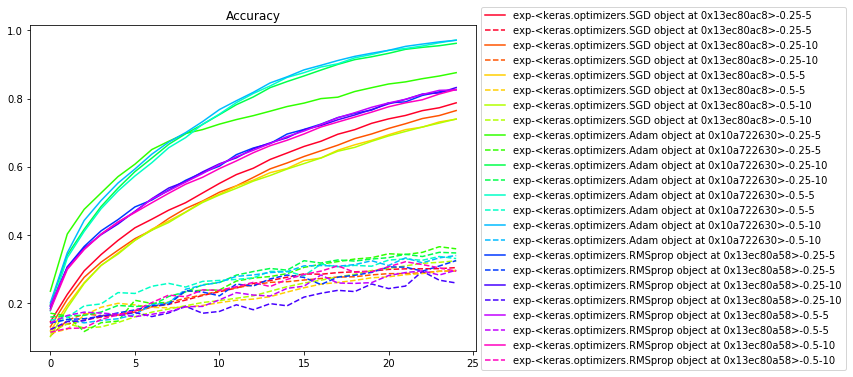

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()